In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields
from DataFields import DateReportedFields
from ProjectFunctions import get_columns_from_chunk, convert_date_to_binary, drop_rows_with_na_greater_than
from ProjectFunctions import map_education_levels, map_vascular_levels

UKBB_PATH = "~/biobank/ukb672220.csv"

# A dictionary containing the used features
datafields = DataFields

# Features of conditions specified by date
datereportedfields = DateReportedFields

#### Measure the distribution of age

Counts [340 695 447 263  73  60  38  11   6   6]
Edges: [1937.  1939.8 1942.6 1945.4 1948.2 1951.  1953.8 1956.6 1959.4 1962.2
 1965. ]


,Unnamed: 0.1,Unnamed: 0,Birth Year,Sex,Education,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,Ever Smoked,...,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia
count,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,...,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.000000,1939.0
mean,969.000000,1097.936565,1943.169159,0.591542,1.198059,0.789067,0.003094,28.538064,0.705227,0.675606,...,16.539562,4.488396,13.727148,0.064500,1.440413,7.347432,82.148589,147.129882,70.930870,1.0
std,559.885405,629.101967,4.233419,0.491675,1.121375,0.408076,0.055555,5.076493,0.676504,0.468269,...,0.534139,0.441748,1.098247,0.035512,0.810186,1.967500,10.752298,20.145493,12.725843,0.0
min,0.000000,0.000000,1937.000000,0.000000,0.000000,0.000000,0.000000,15.757600,0.000000,0.000000,...,15.200000,1.720000,11.490000,0.012000,0.263000,2.370000,47.000000,78.000000,35.000000,1.0
25%,484.500000,553.000000,1940.000000,0.000000,0.000000,1.000000,0.000000,25.070900,0.000000,0.000000,...,16.200000,4.200000,13.100000,0.046000,1.028000,6.040000,75.000000,133.000000,63.000000,1.0
50%,969.000000,1109.000000,1942.000000,1.000000,1.000000,1.000000,0.000000,27.805800,1.000000,1.000000,...,16.500000,4.483000,13.530000,0.061000,1.340000,7.120000,82.000000,146.000000,70.000000,1.0
75%,1453.500000,1642.500000,1945.000000,1.000000,2.000000,1.000000,0.000000,31.385453,1.000000,1.000000,...,16.860000,4.769500,14.100000,0.078000,1.739000,8.440000,89.000000,159.000000,78.000000,1.0
max,1938.000000,2185.000000,1965.000000,1.000000,3.000000,1.000000,1.000000,54.528300,2.000000,1.000000,...,19.400000,6.390000,31.700000,1.077000,25.278000,34.130000,132.000000,241.000000,169.000000,1.0


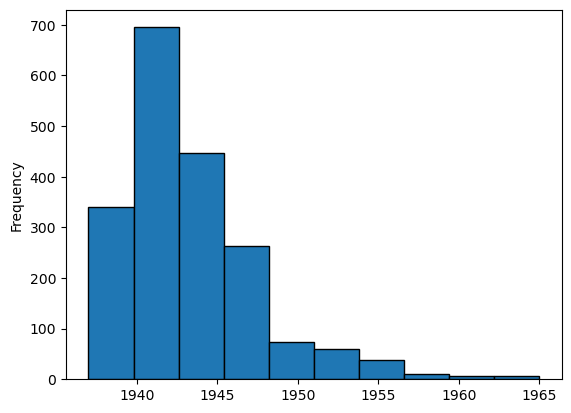

In [2]:
df = pd.read_csv("diagnosed_imputed.csv")

# plot histogram of the birth year
df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')
birth_year_counts_histogram, birth_year_histogram_edges = np.histogram(df["Birth Year"], bins=10)
print(f"Counts {birth_year_counts_histogram}")
print(f"Edges: {birth_year_histogram_edges}")
# describe the birth year
df.describe()

#### Extract samples of patients undiagnosed with vascular dementia with similar birth year

In [7]:
drop_if_na_list = [
    "Smoking Status",
    "Education",
    "Ever Smoked",
    "Report of Vascular problems",
    
    "Alanine aminotransferase",
    "Albumin",
    "Alkaline phosphatase",
    "Apolipoprotein A",
    "Apolipoprotein B",
    "Aspartate aminotransferase",
    "C-reactive protein",
    "Calcium",
    "Cholesterol",
    "Creatinine",
    "Cystatin C",
    "Direct bilirubin",
    "Gamma glutamyltransferase",
    "Glucose",
    "Glycated haemoglobin (HbA1c)",
    "HDL cholesterol",
    "IGF-1",
    "LDL direct",
    "Lipoprotein A",
    "Phosphate",
    "SHBG",
    "Testosterone",
    "Total bilirubin",
    "Total protein",
    "Triglycerides",
    "Urate",
    "Urea",
    "Vitamin D",
    
    "Basophil count",
    "Basophil percentage",
    "Eosinophil count",
    "Eosinophil percentage",
    "Haematocrit percentage",
    "Haemoglobin concentration",
    "High light scatter reticulocyte count",
    "High light scatter reticulocyte percentage",
    "Immature reticulocyte fraction",
    "Lymphocyte count",
    "Lymphocyte percentage",
    "Mean corpuscular haemoglobin",
    "Mean corpuscular haemoglobin concentration",
    "Mean corpuscular volume",
    "Mean platelet (thrombocyte) volume",
    "Mean reticulocyte volume",
    "Mean sphered cell volume",
    "Monocyte count",
    "Monocyte percentage",
    "Neutrophil count",
    "Neutrophil percentage",
    "Nucleated red blood cell count",
    "Nucleated red blood cell percentage",
    "Platelet count",
    "Platelet crit",
    "Platelet distribution width",
    "Red blood cell (erythrocyte) count",
    "Red blood cell (erythrocyte) distribution width",
    "Reticulocyte count",
    "Reticulocyte percentage",
    "White blood cell (leukocyte) count",
    "Blood Pressure Diastolic",
    "Blood Pressure Systolic",
    "Pulse Rate at Blood Pressure"
]

In [10]:
# Sample "count" rows from dataframe following a condtion by chunks randomly.
def sample_by_condition(file_path, column, condition_function, count, samples_per_chunk, drop_na_count, chunksize=10000):
    result = pd.DataFrame()
    samples_collected = 0

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        # remove unnecessary columns first.
        chunk = get_columns_from_chunk(chunk, datafields, oldest=True)

        # filter by condition function
        mask = condition_function(chunk[column])
        filtered_chunk = chunk.loc[mask]

        # convert items with value less than 0 to NA
        filtered_chunk = filtered_chunk.mask(filtered_chunk.select_dtypes(include='number') < 0)

        # drop all NA
        filtered_chunk = filtered_chunk.dropna(subset=drop_if_na_list) # drop if missing value for some columns

        
        if filtered_chunk.empty:
            continue
    
        remaining_samples = count - samples_collected
        if remaining_samples <= 0:
            break
    
        k = min(samples_per_chunk, len(filtered_chunk))
        
        chunk_sample = filtered_chunk.sample(n=k)
    
        if result.empty:
            result = chunk_sample
        else:
            result = pd.concat([result, chunk_sample], ignore_index=True, copy=False)

        samples_collected += len(chunk_sample)

        if samples_collected >= count:
            break
    if samples_collected > count:
        return result.sample(n=count)
    else:
        return result

In [11]:
per_chunk = 500 # maximum samples to take from a single chunk per histogram column
col_name = "Birth Year" # The column to use as a rule for "sample_by_condition"
vd_1 = "Vascular Dementia Date First Reported" # vd_1 and vd_2 used to drop diagnosed patients
vd_2 = "Date of vascular dementia report"
drop_na_count = 25 # drop rows with larger NA features count.

mult = 1.0 # multiply number of people per histogram
const = 20 # constant addition per histogram

undiagnosed_df = pd.DataFrame()

for i in range(len(birth_year_counts_histogram)):
    start, end = birth_year_histogram_edges[i], birth_year_histogram_edges[i+1]
    count = birth_year_counts_histogram[i]
    
    df = sample_by_condition(UKBB_PATH, col_name, lambda x:(x >= start) & (x < end), int(count*mult + const), per_chunk, drop_na_count)
    
    df = df[df[vd_1].isna() & df[vd_2].isna()] # drop if has vascular dementia
    
    df = convert_date_to_binary(df, DateReportedFields)
    
    undiagnosed_df = pd.concat([undiagnosed_df, df], ignore_index=True)

# drop vascular dementia columns, and assign new with 0 (undiagnosed)
undiagnosed_df = undiagnosed_df.drop(columns=[vd_1, vd_2])
undiagnosed_df["Has Vascular Dementia"] = 0

# map education
undiagnosed_df = map_education_levels(undiagnosed_df)

# map vascular
undiagnosed_df = map_vascular_levels(undiagnosed_df)

undiagnosed_df = undiagnosed_df.drop(columns=["id"])

#### Save the CSV, and analyse the extracted data

Birth Year: 0 missing values
Sex: 0 missing values
Education: 0 missing values
Primary Hypertension: 0 missing values
Secondary Hypertension: 0 missing values
BMI Impedance: 0 missing values
Smoking Status: 0 missing values
Ever Smoked: 0 missing values
Alcohol Intake Frequency: 0 missing values
Report of stroke: 0 missing values
Diabetes Diagnosed By Doctor: 0 missing values
Stress Reported: 0 missing values
Report of Vascular problems: 0 missing values
Seropositive Rheumatoid Arthritis: 0 missing values
Other Rheumatoid Arthritis: 0 missing values
Juvenile Arthritis: 0 missing values
Other Arthritis: 0 missing values
Psoriatic and enteropathic arthropathies: 0 missing values
Multiple Sclerosis: 0 missing values
Crohn's disease: 0 missing values
Ulcerative Colitis: 0 missing values
Thyrotoxicosis (Grave's disease): 0 missing values
Sjogren Disease (M35): 0 missing values
Myasthenia gravis: 0 missing values
Diagnosed with Coeliac disease: 0 missing values
B12 deficiency anaemia: 0 miss

,Birth Year,Sex,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Report of stroke,Diabetes Diagnosed By Doctor,...,Platelet distribution width,Red blood cell (erythrocyte) count,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Reticulocyte percentage,White blood cell (leukocyte) count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia
count,2124.000000,2124.000000,2124.0,2124.0,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,...,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.0
mean,1944.018832,0.646422,0.0,0.0,28.484640,0.589454,0.653955,2.706215,0.104520,0.106874,...,16.529609,4.595809,13.530024,0.065271,1.421894,7.053008,84.861582,150.380885,69.870527,0.0
std,5.261295,0.478193,0.0,0.0,4.527593,0.615395,0.475820,1.551848,0.306006,0.309026,...,0.527401,0.404562,1.040993,0.024166,0.520866,1.925742,10.898178,19.834179,12.823844,0.0
min,1937.000000,0.000000,0.0,0.0,17.508100,0.000000,0.000000,1.000000,0.000000,0.000000,...,13.710000,2.737000,11.630000,0.010000,0.210000,3.000000,47.000000,83.000000,38.000000,0.0
25%,1940.000000,0.000000,0.0,0.0,25.509575,0.000000,0.000000,1.000000,0.000000,0.000000,...,16.150000,4.330750,12.977500,0.048000,1.060000,5.810000,77.000000,136.000000,61.000000,0.0
50%,1942.000000,1.000000,0.0,0.0,27.839400,1.000000,1.000000,2.000000,0.000000,0.000000,...,16.485000,4.597000,13.400000,0.062000,1.350000,6.850000,85.000000,149.000000,69.000000,0.0
75%,1946.000000,1.000000,0.0,0.0,30.787425,1.000000,1.000000,4.000000,0.000000,0.000000,...,16.820000,4.861000,13.900000,0.080000,1.720500,8.030000,92.000000,162.000000,78.000000,0.0
max,1964.000000,1.000000,0.0,0.0,59.188300,2.000000,1.000000,6.000000,1.000000,1.000000,...,19.310000,6.040000,37.190000,0.211000,5.160000,30.350000,133.000000,240.000000,118.000000,0.0


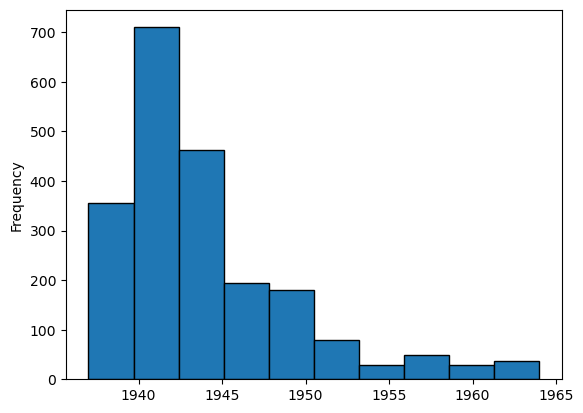

In [12]:
from ProjectFunctions import count_na_in_dataframe

undiagnosed_df = undiagnosed_df.dropna()

# count number of NA per column
count_na_in_dataframe(undiagnosed_df)

# Plot Brith Year histogram, compare with diagnosed patients
undiagnosed_df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')

undiagnosed_df.to_csv("undiagnosed.csv")

# analyze distributions
undiagnosed_df.describe()